# **NuCLS Dataset Exploratory Data Analysis (EDA)**

This document offers a quick analysis of the NuCLS in this repository.

## **Download packages**

In [4]:
import pandas as pd
import numpy as np

from PIL import Image, ImageOps
import datasets
from datasets import load_dataset, concatenate_datasets
import os
import io
from typing import Tuple, Dict, List

import random
import zipfile
import requests
from io import BytesIO

import seaborn as sns
from collections import defaultdict, Counter
import matplotlib.cm as cm

import matplotlib.pyplot as plt
import matplotlib.patches as patches


import yaml

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Set the working directory in Google Drive
os.chdir('/content/drive/MyDrive/YOLOV8')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **1. Load the Dataset**

In [5]:
# Load the dataset
dataset = load_dataset("minhanhto09/NuCLS_dataset", name="default")
# Combine folds into train and test
train_splits = [dataset[f'train_fold_{i}'] for i in range(1, 6)]
combined_train = concatenate_datasets(train_splits)

test_splits = [dataset[f'test_fold_{i}'] for i in range(1, 6)]
combined_test = concatenate_datasets(test_splits)

# Create a new dataset dictionary
dataset = {'train': combined_train, 'test': combined_test}

In [11]:
test = dataset['test']
train = dataset['train']

## **Investigate the Dataset**

file_name: TCGA-AN-A0XU-DX1_id-5ea40b25ddda5f83989991fd_left-26871_top-22266_bottom-22546_right-27160


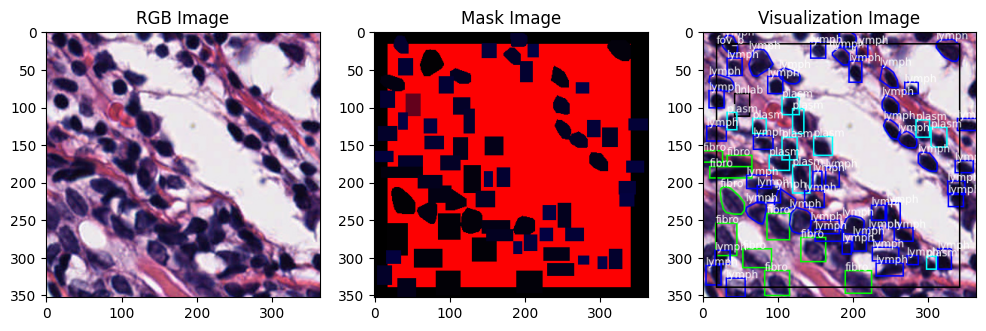

raw_classification: ['lymphocyte', 'lymphocyte', 'lymphocyte', 'lymphocyte', 'lymphocyte', 'fibroblast', 'fibroblast', 'lymphocyte', 'fibroblast', 'fibroblast', 'fibroblast', 'fibroblast', 'fibroblast', 'fibroblast', 'lymphocyte', 'plasma_cell', 'lymphocyte', 'lymphocyte', 'lymphocyte', 'lymphocyte', 'lymphocyte', 'lymphocyte', 'lymphocyte', 'lymphocyte', 'lymphocyte', 'lymphocyte', 'lymphocyte', 'lymphocyte', 'lymphocyte', 'unlabeled', 'plasma_cell', 'plasma_cell', 'fibroblast', 'lymphocyte', 'lymphocyte', 'plasma_cell', 'lymphocyte', 'plasma_cell', 'lymphocyte', 'lymphocyte', 'lymphocyte', 'lymphocyte', 'lymphocyte', 'lymphocyte', 'lymphocyte', 'plasma_cell', 'lymphocyte', 'plasma_cell', 'lymphocyte', 'lymphocyte', 'lymphocyte', 'lymphocyte', 'lymphocyte', 'lymphocyte', 'lymphocyte', 'fibroblast', 'plasma_cell', 'lymphocyte', 'lymphocyte', 'lymphocyte', 'lymphocyte', 'plasma_cell', 'lymphocyte', 'plasma_cell', 'lymphocyte', 'lymphocyte', 'lymphocyte', 'lymphocyte', 'lymphocyte', 'pla

In [7]:
# An entry of the dataset

entry_0 = train[0]
print('file_name:', entry_0['file_name'])

# Show 3 images in 1 canvas
rgb_image = entry_0['rgb_image']
mask_image = entry_0['mask_image']
visualization_image = entry_0['visualization_image']

plt.figure(figsize=(12, 7))
plt.subplot(1, 3, 1)
plt.imshow(rgb_image)
plt.title('RGB Image')
plt.subplot(1, 3, 2)
plt.imshow(mask_image)
plt.title('Mask Image')
plt.subplot(1, 3, 3)
plt.imshow(visualization_image)
plt.title('Visualization Image')
plt.show()

# Show annotation coordinates
print('raw_classification:', entry_0['annotation_coordinates']['raw_classification'])
print('main_classification:', entry_0['annotation_coordinates']['main_classification'])
print('super_classification:', entry_0['annotation_coordinates']['super_classification'])
print('type:', entry_0['annotation_coordinates']['type'])
print('xmin:', entry_0['annotation_coordinates']['xmin'])
print('ymin:', entry_0['annotation_coordinates']['ymin'])
print('xmax:', entry_0['annotation_coordinates']['xmax'])
print('ymax:', entry_0['annotation_coordinates']['ymax'])
print('coords_x:', entry_0['annotation_coordinates']['coords_x'])
print('coords_y:', entry_0['annotation_coordinates']['coords_y'])


Image width: 364
Image height: 353
Image resolution: (353, 364, 3)
Image width: 366
Image height: 391
Image resolution: (391, 366, 3)
Image width: 365
Image height: 339
Image resolution: (339, 365, 3)


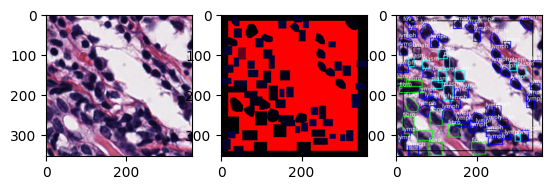

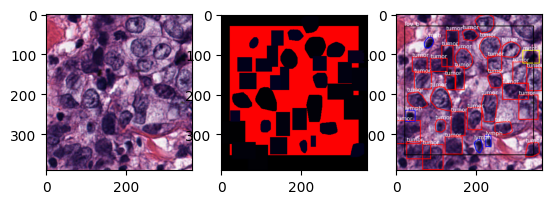

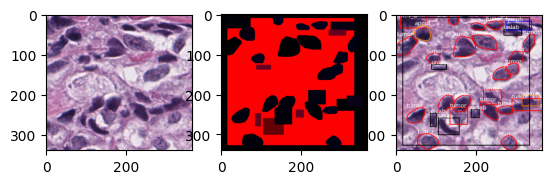

In [8]:
# Display the first 3 entries' images and their sizes

for i in range(0,3):
    rgb_image = train[i]['rgb_image']
    mask_image = train[i]['mask_image']
    visualization_image = train[i]['visualization_image']

    # Convert to numpy
    rgb_image = np.array(rgb_image)
    mask_image = np.array(mask_image)
    visualization_image = np.array(visualization_image)

    # Display the images
    fig, axes = plt.subplots(1, 3)
    axes[0].imshow(rgb_image)
    axes[1].imshow(mask_image)
    axes[2].imshow(visualization_image)

    # show the image width, height and resolution
    print(f"Image width: {rgb_image.shape[1]}")
    print(f"Image height: {rgb_image.shape[0]}")
    print(f"Image resolution: {rgb_image.shape}")

In [9]:
# A function to plot the bounding boxes from the annotation_coordinates

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_annotated_image_with_labels(entry):
    rgb_image = entry['rgb_image']
    annotation_coords = entry['annotation_coordinates']

    # Create a figure and a single subplot
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(rgb_image)

    # Get bounding box coordinates and classifications
    xmin = annotation_coords['xmin']
    xmax = annotation_coords['xmax']
    ymin = annotation_coords['ymin']
    ymax = annotation_coords['ymax']
    labels_super = annotation_coords['super_classification']
    labels_raw = annotation_coords['raw_classification']
    labels_main = annotation_coords['main_classification']


    for x3, y3, x4, y4, label2 in zip(xmin, ymin, xmax, ymax, labels_super):
        # Draw the rectangle
        rect = patches.Rectangle((x3, y3), x4 - x3, y4 - y3, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        # Place a text label
        ax.text(x3, y3, label2, fontsize=8, bbox=dict(facecolor='yellow', alpha=0.5), verticalalignment='top')

    # Set plot titles and labels
    plt.title('Annotated RGB Image with SuperClass_Labels')
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(rgb_image)
    for x1, y1, x2, y2, label in zip(xmin, ymin, xmax, ymax, labels_main):
        # Draw the rectangle
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        # Place a text label
        ax.text(x1, y1, label, fontsize=8, bbox=dict(facecolor='green', alpha=0.5), verticalalignment='top')
    plt.title('Annotated RGB Image with MainClass_Labels')
    plt.show()

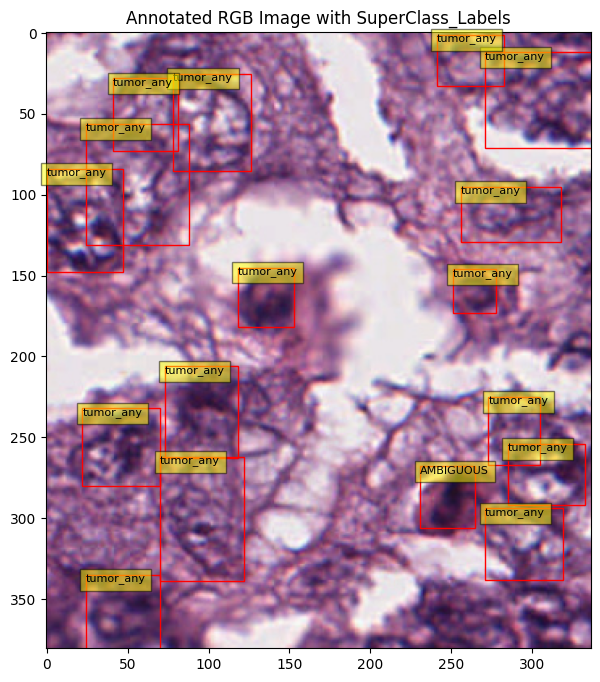

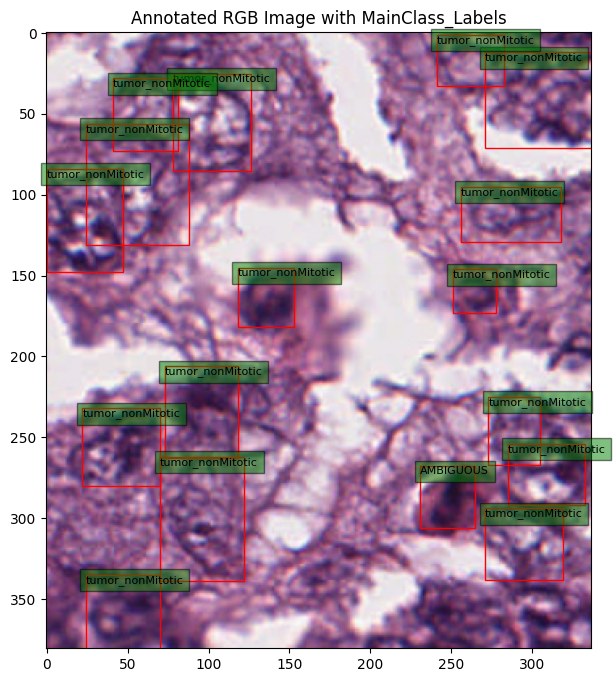

In [13]:
# Example of how to use this function with our dataset
entry_0 = test[1]
plot_annotated_image_with_labels(entry_0)

## **Exploratory Data Analysis (EDA)**

Unique train hospital codes and their counts: {'AN': 432, 'D8': 732, 'A2': 1344, 'EW': 552, 'S3': 172, 'AO': 168, 'E2': 836, 'GM': 504, 'A7': 536, 'AQ': 72, 'C8': 104, 'LL': 112, 'AR': 340, 'GI': 20, 'OL': 456, 'BH': 432, 'A1': 92, 'AC': 72}
Number of different train hospitals: 18
Unique test hospital codes and their counts: {'OL': 114, 'BH': 108, 'A1': 23, 'AC': 18, 'AN': 108, 'A2': 336, 'S3': 43, 'AQ': 18, 'AO': 42, 'E2': 209, 'GM': 126, 'LL': 28, 'D8': 183, 'C8': 26, 'AR': 85, 'EW': 138, 'A7': 134, 'GI': 5}
Number of different test hospitals: 18


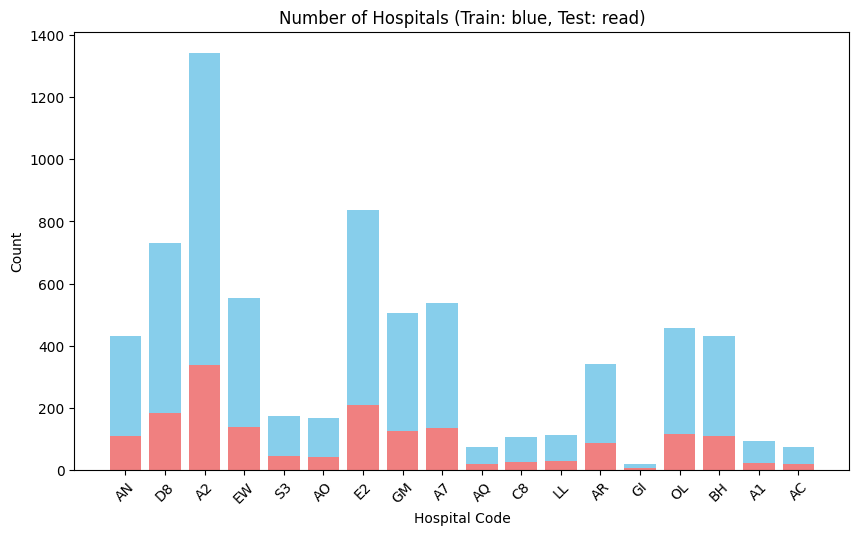

In [14]:
# Function to count different hospitals from a list
def count_hospitals(file_names):
    hospital_counts = {}
    for file_name in file_names:
        parts = file_name.split("-")
        if len(parts) > 1:
            hospital_code = parts[1]
            if hospital_code not in hospital_counts:
                hospital_counts[hospital_code] = 0
            hospital_counts[hospital_code] += 1
    return hospital_counts

# Count the hospitals
hospital_counts_train = count_hospitals(train['file_name'])
hospital_counts_test = count_hospitals(test['file_name'])

# Combine the counts
combined_counts = {**hospital_counts_train, **hospital_counts_test}

# Printing the result
print(f"Unique train hospital codes and their counts: {hospital_counts_train}")
print(f"Number of different train hospitals: {len(hospital_counts_train)}")
print(f"Unique test hospital codes and their counts: {hospital_counts_test}")
print(f"Number of different test hospitals: {len(hospital_counts_test)}")
#print(f"Combined hospital counts: {combined_counts}")

# Extract hospital codes and their counts
hospital_codes_train = list(hospital_counts_train.keys())
counts_train = list(hospital_counts_train.values())
hospital_codes_test = list(hospital_counts_test.keys())
counts_test = list(hospital_counts_test.values())

# Creating the bar plot
plt.figure(figsize=(10, 6)) # Adjust the size as needed
plt.bar(hospital_codes_train, counts_train, color='skyblue')
plt.bar(hospital_codes_test, counts_test, color='lightcoral')

plt.title('Number of Hospitals (Train: blue, Test: read)')
plt.xlabel('Hospital Code')
plt.ylabel('Count')

# Optional: Rotate the x-axis labels for better readability
# Make the plot a bit smaller
plt.subplots_adjust(bottom=0.15)
plt.xticks(rotation=45)

plt.show()

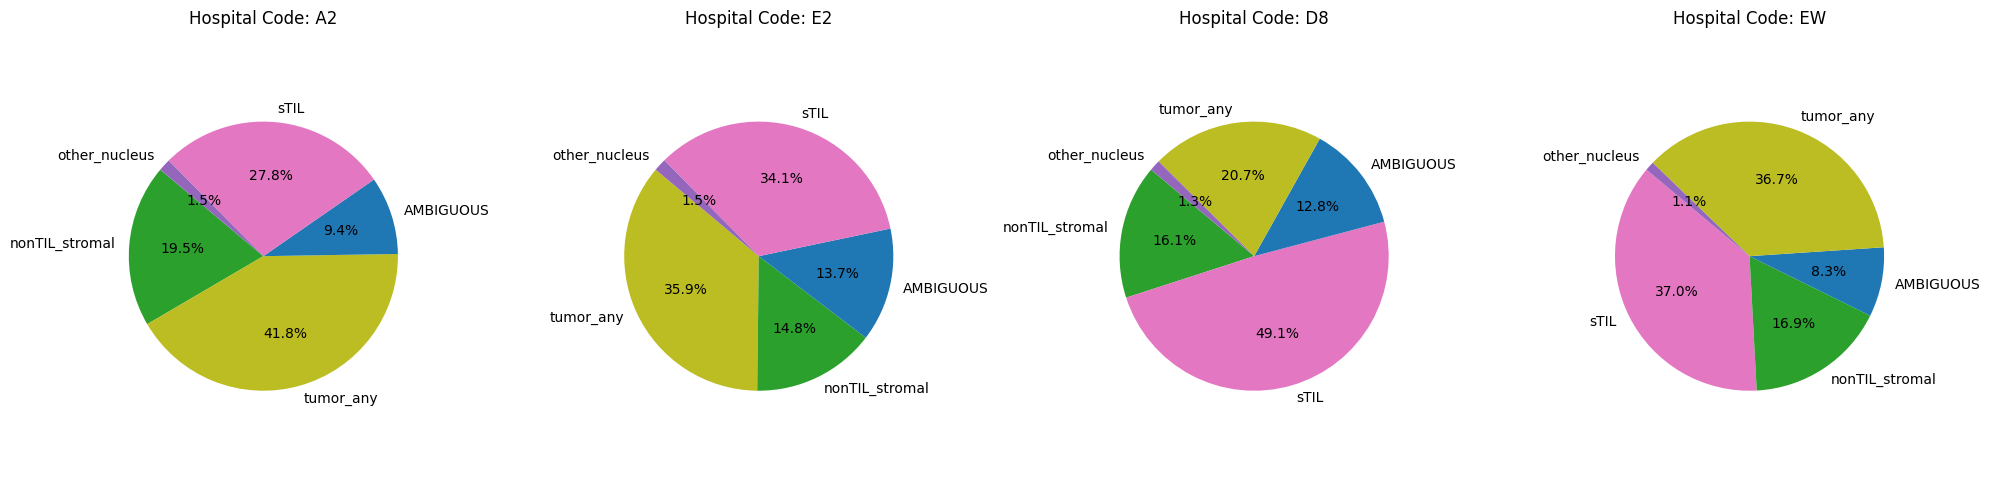

In [15]:
# Specify the hospital codes for which you want to create pie charts
hospital_codes_to_plot = ['A2', 'E2', 'D8', 'EW']

# Initialize counters for each hospital code
classification_counts = {code: Counter() for code in hospital_codes_to_plot}

# Gather all unique labels from the dataset for the specified hospitals
all_labels = set()
for entry in train:
    file_name = entry['file_name']
    parts = file_name.split("-")
    if len(parts) > 1 and parts[1] in hospital_codes_to_plot:
        classifications = entry["annotation_coordinates"]["super_classification"]
        all_labels.update(classifications)

# Sort labels to maintain consistency
sorted_labels = sorted(all_labels)

# Create a color map: each label gets a color from the colormap
label_colors = {label: cm.tab20(i / len(sorted_labels)) for i, label in enumerate(sorted_labels)}

# Iterate through each entry in the dataset again to fill classification_counts
for entry in train:
    file_name = entry['file_name']
    parts = file_name.split("-")
    if len(parts) > 1:
        hospital_code = parts[1]
        if hospital_code in hospital_codes_to_plot:
            # Extract classifications and update the counter for the relevant hospital
            classifications = entry["annotation_coordinates"]["super_classification"]
            classification_counts[hospital_code].update(classifications)

# Plotting the pie charts with color consistency
fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # Adjust the figsize as needed
for i, hospital_code in enumerate(hospital_codes_to_plot):
    labels = list(classification_counts[hospital_code].keys())
    sizes = list(classification_counts[hospital_code].values())
    colors = [label_colors[label] for label in labels]  # Get the colors for current labels

    if labels and sizes:  # Ensure there's data to plot
        axs[i].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
        axs[i].axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle
        axs[i].set_title(f'Hospital Code: {hospital_code}')
    else:
        axs[i].text(0.5, 0.5, 'No Data', ha='center', va='center', fontsize=12)
        axs[i].set_title(f'Hospital Code: {hospital_code}')

plt.tight_layout()
plt.show()


In [17]:
# Function to aggregate nuclei frequencies
def aggregate_nuclei_frequencies(dataset):
    hospital_nuclei_counts = defaultdict(Counter)

    for entry in dataset:
        # Extract hospital code from the file_name
        hospital_code = entry['file_name'].split('-')[1]
        # Aggregate the count of each nucleus type
        for nucleus_type in entry['annotation_coordinates']['super_classification']:
            hospital_nuclei_counts[hospital_code][nucleus_type] += 1

    return hospital_nuclei_counts

train_fold_1_counts = aggregate_nuclei_frequencies(train)
test_fold_1_counts = aggregate_nuclei_frequencies(test)

# Combine aggregated data
combined_counts = {**train_fold_1_counts, **test_fold_1_counts}
for key in combined_counts:
    if key in train_fold_1_counts and key in test_fold_1_counts:
        combined_counts[key] = combined_counts[key] + test_fold_1_counts[key]

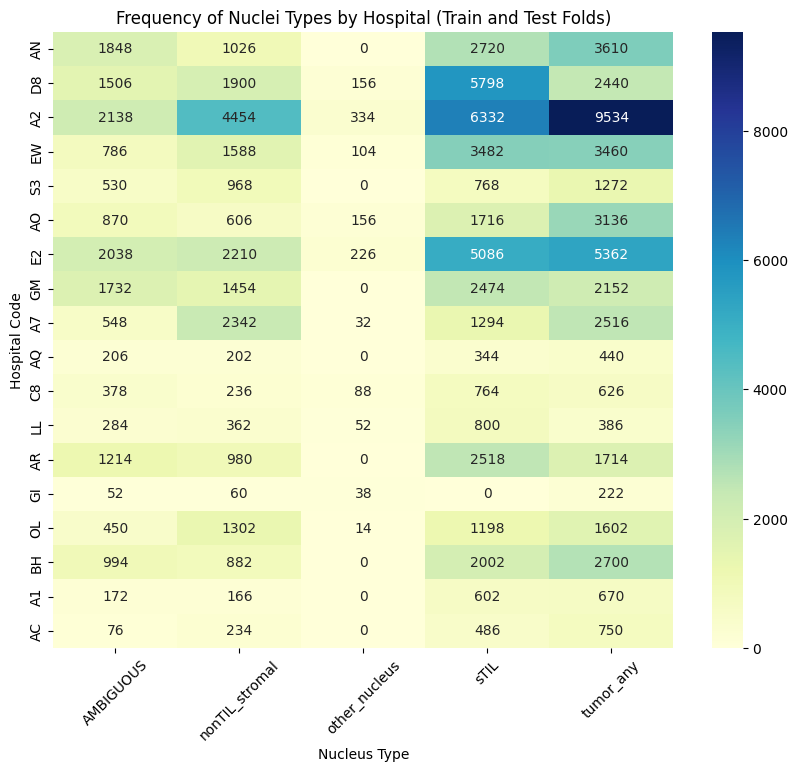

In [18]:
# Assuming combined_counts is the aggregated data
labels = list(combined_counts.keys())  # Hospital codes

# Generating a list of unique nuclei types
nuclei_types = set()
for counts in combined_counts.values():
    nuclei_types.update(counts.keys())
nuclei_types = sorted(list(nuclei_types))  # Sorting to maintain a consistent order

# Generating the matrix for the heatmap
matrix = np.array([[combined_counts[hospital].get(nucleus, 0) for nucleus in nuclei_types] for hospital in labels])

# Creating a heatmap with the corrected data

plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, fmt="d", cmap="YlGnBu", xticklabels=nuclei_types, yticklabels=labels)
plt.xticks(rotation=45)
plt.title('Frequency of Nuclei Types by Hospital (Train and Test Folds)')
plt.xlabel('Nucleus Type')
plt.ylabel('Hospital Code')
plt.show()


In [21]:
# Calculate total count for each nuclei type
total_nuclei_counts = {nucleus: 0 for nucleus in nuclei_types}

# Iterating through each hospital's data
for hospital_counts in combined_counts.values():
    for nucleus, count in hospital_counts.items():
        total_nuclei_counts[nucleus] += count

# Display the total counts for each nuclei type
for nucleus, total_count in total_nuclei_counts.items():
    print(f"{nucleus}: {total_count}")

AMBIGUOUS: 15822
nonTIL_stromal: 20972
other_nucleus: 1200
sTIL: 38384
tumor_any: 42592


## **EDA Results**

**The bar chart** illustrates each hospital's contribution to the dataset, with longer bars indicating higher sample counts. This underscores potential biases, as models might more accurately predict conditions from hospitals contributing more data.

**The pie charts** offer a snapshot of the cellular composition within histological samples from various hospitals, showcasing the diversity of cell types present. In histopathology, stromal Tumor-Infiltrating Lymphocytes (sTILs) and non-TIL stromal cells (which may include fibroblasts or vascular endothelial cells) serve distinct roles within the tumor microenvironment. Their presence is not inherently "dangerous," but rather reflective of the body's reaction to the tumor or the tumor's characteristics themselves. Such cellular indicators provide crucial insights into the tumor's milieu, aiding pathologists and oncologists in diagnosing and formulating treatment plans.

**The heatmap** presents the distribution of various nuclei types across hospitals. Darker shades denote higher frequencies, highlighting prevalent conditions in specific hospitals, such as significant occurrences of 'tumor_any' nuclei, potentially signifying a specialization in cancer treatment. It also delineates the distribution of other common nuclei like 'sTIL' or 'nonTIL_stromal'. Conversely, lighter shades indicate less common nuclei types, suggesting lower incidence rates or possible biases in sample collection.

Overall, these visualizations equip pathologists and health experts with the ability to rapidly identify trends and anomalies, enhancing the interpretation of data and supporting more informed healthcare decisions.